In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

MAINPATH = '/Users/research/projects/maiasaurus/'

# Build the observed catalogue

In [2]:
# READ IN OBSERVED PLANETS
obs_file = MAINPATH + 'catalogues/syssim_observed_planets_raw.csv'

obs_data = []
with open(obs_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        obs_data.append(row)
        
KEYS = obs_data[20]
VALUES = obs_data[21:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [3]:
obs = {}

obs['target_id'] = getkey('target_id')
obs['star_id']   = getkey('star_id')

obs['period']    = getkey('period')
obs['depth']     = getkey('depth')
obs['duration']  = getkey('duration')

obs['star_mass']   = getkey('star_mass')
obs['star_radius']   = getkey('star_radius')

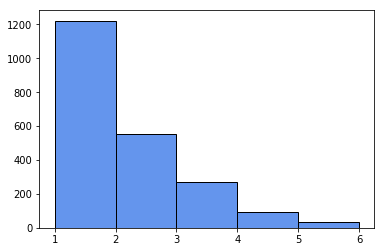

2183 planets in 1622 OBSERVED systems


In [4]:
npl = np.zeros_like(obs['target_id'], dtype='int')

for i, sid in enumerate(obs['target_id']):
    npl[i] = np.sum(obs['target_id'] == sid)

obs['npl'] = npl
    
plt.figure()
plt.hist(npl, bins=np.arange(1,npl.max()+1), color='cornflowerblue', edgecolor='k')
plt.show()

print('%d planets in %d OBSERVED systems' %(len(obs['target_id']), len(np.unique(obs['target_id']))))

# Build the underlying physical catalogue

In [5]:
# READ IN PHYSICAL PLANETS
phys_file = MAINPATH +'catalogues/syssim_physical_planets_raw.csv'

phys_data = []
with open(phys_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        phys_data.append(row)
        
KEYS = phys_data[20]
VALUES = phys_data[21:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [6]:
phys = {}

phys['target_id'] = getkey('target_id')
phys['star_id'] = getkey('star_id')

phys['planet_mass'] = getkey('planet_mass')
phys['planet_radius'] = getkey('planet_radius')

phys['clusterid'] = getkey('clusterid')
phys['period'] = getkey('period')
phys['ecc'] = getkey('ecc')

phys['star_mass'] = getkey('star_mass')
phys['star_radius'] = getkey('star_radius')

In [7]:
# only keep (twin) systems with at least one planet detected
keep = np.isin(phys['star_id'], obs['star_id'])

for k in phys.keys():
    phys[k] = phys[k][keep]

## IMPORTANT NOTE

* "target_id" is a unique identifier for a system in the physical catalogue

* "star_id" may be shared between systems because stars are reused during simulation (for efficiency)

Due to an earlier confusion between these terms, I mistakenly marked all systems for which "star_id" had at least one observed planet. This led to high multiplicities (>20) because I was combining multiple systems - all with the same star_id - into a single system. So, the "physical_systems" catalogue I sent to Andrew contained ~12000 planets, ~3200 of which were around stars which did not have detected planets but which had stellar twins which did have detected planets.

So there are two outputs from this notebook:

1. "syssim_physical_planets_including_twins" contains the (falsely included) twin systems; ~12000 objects
2. "syssim_physical_planets" contains only the real systems; ~8800 objects

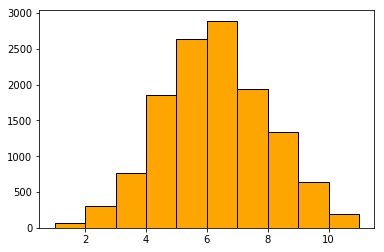

In [8]:
npl = np.zeros_like(phys['target_id'], dtype='int')

for i, sid in enumerate(phys['target_id']):
    npl[i] = np.sum(phys['target_id'] == sid)

phys['npl'] = npl
    
plt.figure()
plt.hist(npl, bins=np.arange(1,npl.max()+1), color='orange', edgecolor='k')
plt.show()

In [9]:
print('%d planets in %d (TWIN) PHYSICAL systems' %(len(phys['target_id']), len(np.unique(phys['target_id']))))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/syssim_physical_planets_including_twins.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(phys.keys())
        writer.writerows(zip(*phys.values()))

12609 planets in 2475 (TWIN) PHYSICAL systems


# Read in the masses from Andrew

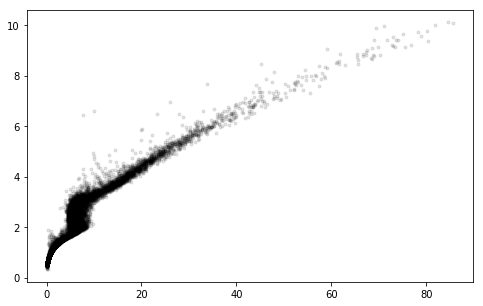

In [10]:
# read in mass
phys['radius'] = np.load(MAINPATH + 'catalogues/syssim_physical_pred_masses_dec17.npy')[0]
phys['mass']   = np.load(MAINPATH + 'catalogues/syssim_physical_pred_masses_dec17.npy')[3]

plt.figure(figsize=(8,5))
plt.plot(phys['mass'], phys['radius'], 'k.', alpha=0.1)
plt.show()

In [11]:
# Eliminate the false twin systems
keep = np.isin(phys['target_id'], obs['target_id'])

for k in phys.keys():
    phys[k] = phys[k][keep]

In [12]:
print('%d planets in %d PHYSICAL systems' %(len(phys['target_id']), len(np.unique(phys['target_id']))))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/syssim_physical_planets.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(phys.keys())
        writer.writerows(zip(*phys.values()))

8865 planets in 1622 PHYSICAL systems


# Identify which systems are in the observed catalogue

In [13]:
# pull observed/physical periods and IDs
obs_per  = np.array(obs['period'], dtype='float')
phys_per = np.array(phys['period'], dtype='float')
phys_rad = np.array(phys['radius'], dtype='float')
phys_mass = np.array(phys['mass'], dtype='float')

obs_id  = np.array(obs['target_id'], dtype='int')
phys_id = np.array(phys['target_id'], dtype='int')


# new lists of TRUE DETECTED periods (slightly different than observed due to simulated measurement uncertainty)
true_per = np.zeros_like(obs_per)
true_rad = np.zeros_like(obs_per)
obs_mass = np.zeros_like(obs_per)


# iterate over all OBSERVED periods
for i, per in enumerate(obs_per):
    
    # pull the PHYSICAL periods for this system
    phys_per_in_this_system = phys_per[phys_id == obs_id[i]]
    phys_rad_in_this_system = phys_rad[phys_id == obs_id[i]]
    phys_mass_in_this_system = phys_mass[phys_id == obs_id[i]]
        
    # select the physical period closest to the observed period and record it as the DETECTED period
    loc = np.argmin(np.abs(phys_per_in_this_system - obs_per[i]))
    
    true_per[i] = phys_per_in_this_system[loc]
    true_rad[i] = phys_rad_in_this_system[loc]
    obs_mass[i] = phys_mass_in_this_system[loc]
    
    
obs['radius'] = true_rad
obs['mass'] = obs_mass

In [14]:
# make DETECTED catalogue (very similar to OBSERVED)
det = obs.copy()
det['period'] = true_per


# make UNDETECTED catalogue
keep = np.isin(phys_per, true_per)
und  = phys.copy()

for k in und.keys():
    und[k] = und[k][~keep]

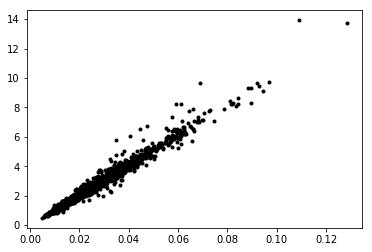

In [22]:
plt.plot(obs['depth']**0.5, obs['radius']/obs['star_radius'], 'k.')

In [ ]:
# pull observed/physical IDs
obs_id = np.array(obs['target_id'], dtype='int')
det_id = np.array(det['target_id'], dtype='int')

# pull observed periods; make radius & mass arrays
obs_per  = np.array(obs['period'], dtype='float')
obs_rad  = np.zeros_like(obs_per)
obs_mass = np.zeros_like(obs_per)

# iterate over all OBSERVED periods
for i, per in enumerate(obs_per):
    
    # pull the DETECTED periods, masses, and radii for this system
    det_per_in_this_system  = det['period'][det_id == obs_id[i]]
    det_rad_in_this_system  = det['radius'][det_id == obs_id[i]]
    det_mass_in_this_system = det['mass'][det_id == obs_id[i]]

    
    # identify the DETECTED period closest to the OBSERVED period
    loc = np.argmin(np.abs(det_per_in_this_system - obs_per[i]))

    obs_rad[i] = det_rad_in_this_system[loc]
    obs_mass[i] = det_mass_in_this_system[loc]
    
    
# add radius and mass to the OBSERVED planets catalogue
obs['radius'] = obs_rad
obs['mass'] = obs_mass

In [16]:
# count the OBSERVED planets in each system
obs_uniquesys = np.unique(obs['target_id'])

for us in obs_uniquesys:
    obs['npl'][obs['target_id']==us] = int(np.sum(obs['target_id']==us))

In [17]:
print('%d planets in UNDETECTED catalogue' %len(und['target_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/syssim_undetected_planets_with_masses.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(und.keys())
        writer.writerows(zip(*und.values()))

6682 planets in UNDETECTED catalogue


In [18]:
print('%d planets in OBSERVED catalogue' %len(obs['target_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/syssim_observed_planets_with_masses.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(obs.keys())
        writer.writerows(zip(*obs.values()))

2183 planets in OBSERVED catalogue
